In [1]:
import pickle
from WebQSP.data import load_data
import torch
from tqdm import tqdm
from pprint import pprint
from collections import Counter
import numpy as np
import json
from transformers import BertTokenizer
import os
os.environ['TRANSFORMERS_OFFLINE']='1'

/home/lyt/miniconda3/envs/DocRED/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
en_ent_label = json.load(open('/data/lyt/wikidata-full/wikidata-item-en-label.json'))

In [3]:

ent2id, rel2id, triples, train_loader, val_loader = load_data('data/AnonyQA_Debug/', 'bert', 16)
# ent2id1, rel2id1, triples1, train_loader1, val_loader1, test_loader = pickle.load(open('data/AnonyQA_Debug/debug_small.pkl','rb'))


Read from cache file: data/AnonyQA_Debug/processed.pt (NOTE: delete it if you modified data loading process)
Train number: 984, test number: 504


In [4]:
id2ent = {v:k for k,v in ent2id.items()}


In [5]:
# for data,data1 in zip(val_loader.dataset,val_loader1.dataset):
#     if not torch.equal(data[1]['input_ids'][0],data1[1]['input_ids'][0]):
#         print('fuck')
    # if not torch.equal(data[0],data1[0]):
    #     print(data[0].nonzero(),data1[0].nonzero())
    # if not torch.equal(data[2],data1[2]):
    #     print(data[2].nonzero(),data1[2].nonzero())
    # assert torch.equal(data[2],data1[2])
    # assert torch.equal(data[3],data1[3])

In [6]:
e_scores = pickle.load(open('debug_e_last.pkl','rb'))
# e_scores_val = pickle.load(open('debug_e_last_val.pkl','rb'))


In [7]:
assert len(e_scores) == len(val_loader)

In [8]:

# import matplotlib.pyplot as plt

# row = 4
# col = 4

# fig, axs = plt.subplots(row,col,figsize=(36,18))

# for i,e_last in enumerate( e_scores_val[0]):
#     bins = 100

#     axs[int(i/col),int(i%col)].set_yscale('log')
#     axs[int(i/col),int(i%col)].hist(e_last.numpy(), bins,rwidth=0.7,color='cornflowerblue')
#     axs[int(i/col),int(i%col)].set_xlim([0,1])
#     axs[int(i/col),int(i%col)].set_title(i)

# plt.show()

NameError: name 'plt' is not defined

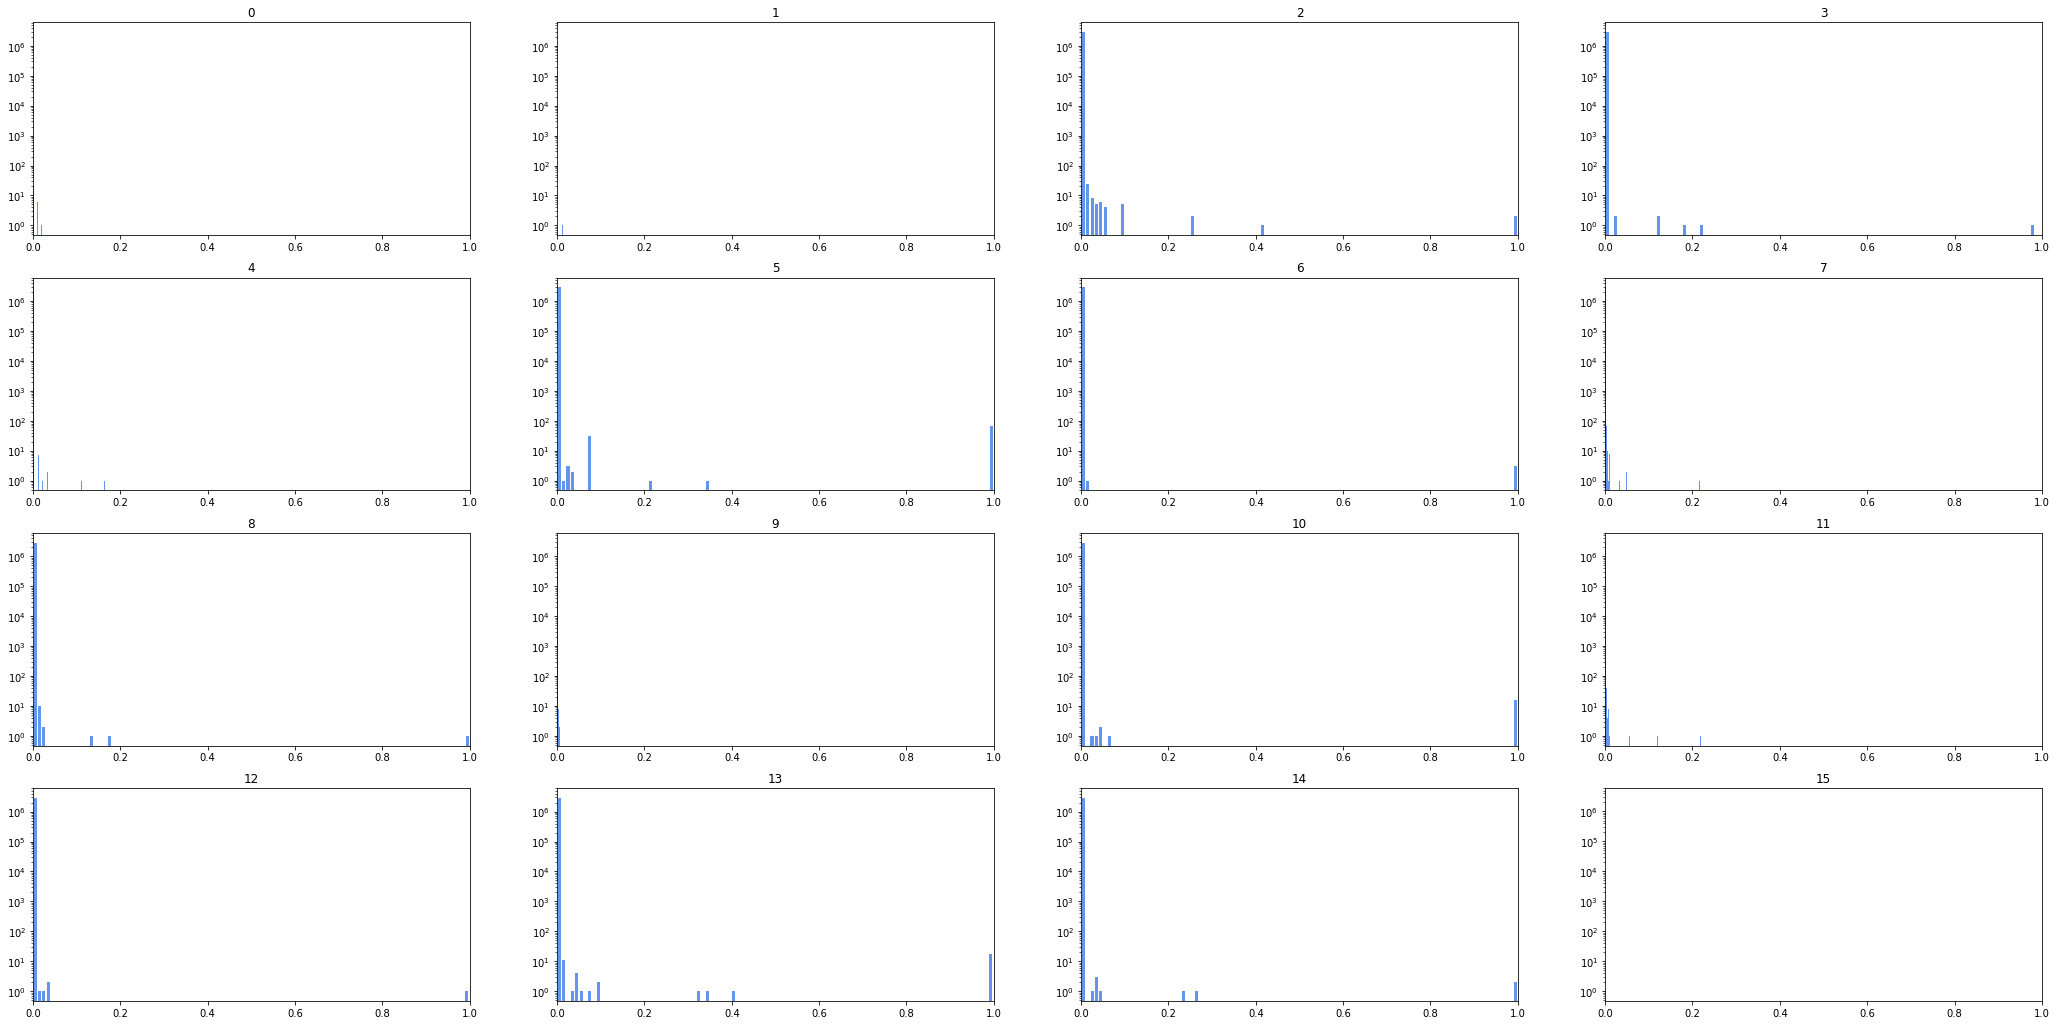

In [ ]:

import matplotlib.pyplot as plt

row = 4
col = 4

fig, axs = plt.subplots(row,col,figsize=(36,18))

for i,e_last in enumerate( e_scores[0]):
    bins = 100

    axs[int(i/col),int(i%col)].set_yscale('log')
    axs[int(i/col),int(i%col)].hist(e_last.numpy(), bins,rwidth=0.7,color='cornflowerblue')
    axs[int(i/col),int(i%col)].set_xlim([0,1])
    axs[int(i/col),int(i%col)].set_title(i)

plt.show()

In [ ]:
total_ans = [[] for i in range(len(val_loader.dataset))] 
total_pred = [[] for i in range(len(val_loader.dataset))] 
topk_acc = 0
threshold_acc = 0
k = 5
threshold = 0.9
for offset,data,e_last in tqdm(zip(range(0,len(val_loader.dataset),16),iter(val_loader),e_scores),total=len(e_scores)):
    answers = data[2]
    entity_range = data[3]

    weight = answers * 999 + 1
    loss = torch.sum(entity_range * weight * torch.pow(e_last - answers, 2)) / torch.sum(entity_range * weight)
    
    threshold_p1 = (e_last>threshold).sum().item() / answers.sum().item()
    threshold_p1 = 1 / threshold_p1 if threshold_p1 > 1 else threshold_p1

    topk_p1 = (len(e_last) * k) / answers.sum().item() if answers.sum().item() > (len(e_last) * k) else answers.sum().item() / (len(e_last) * k)

    topk_acc += torch.gather(answers,1,torch.topk(e_last,k).indices).sum().item() / (len(e_last) * k) * topk_p1
    threshold_acc += torch.logical_and(e_last>threshold,answers).sum().item() / (e_last>threshold).sum().item() * threshold_p1
    for unit_ans in answers.nonzero():
        total_ans[unit_ans[0].item()+offset].append(unit_ans[1].item())
        
    
    for unit_pred in (e_last>threshold).nonzero():
        total_pred[unit_pred[0].item()+offset].append(unit_pred[1].item())

    assert len(total_pred) == len(total_ans), print((e_last>threshold).nonzero(),len(total_pred),len(total_ans))

    
topk_acc /= len(val_loader)
threshold_acc /= len(val_loader)
print(topk_acc)
print(threshold_acc)


100%|██████████| 32/32 [00:15<00:00,  2.01it/s]

0.09906891091129785
0.09181821822401068


In [ ]:
temp = []
for unit in total_pred:
    temp.extend(unit)
print(len(temp))
pred_cnt = Counter(temp)

temp = []
for unit in total_ans:
    temp.extend(unit)
print(len(temp))
ans_cnt = Counter(temp)

85926
1772


In [ ]:
id2ent[1781541]

'Q875538'

In [ ]:
import json
val_dataset = json.load(open('data/AnonyQA_Debug/eval.json'))


In [ ]:
val_dataset[5]

{'question': ' Which film has been filmed in [country_5]?',
 'text': 'Patricia Stephens Due ( December 9 , 1939 – February 7 , 2012 ) was one of the leading African - American civil rights activists in [country_5] , especially in her home state of Florida .Along with her sister Priscilla and others trained in nonviolent protest by CORE , Due spent 49 days in one of the nation \'s first jail - ins , refusing to pay a fine for sitting in a Woolworth \'s " White only " lunch counter in Tallahassee , Florida in 1960 .Her eyes were damaged by tear gas used by police on students marching to protest such arrests , and she wore dark glasses for the rest of her life .She served in many leadership roles in CORE and the NAACP , fighting against segregated stores , buses , theaters , schools , restaurants , and hotels , protesting unjust laws , and leading one of the most dangerous voter registration efforts in the country in northern Florida in the 1960s .With her daughter , Tananarive , Due wrot

In [ ]:
assert len(val_dataset) == len(total_ans),print(len(val_dataset),len(total_ans))

512 504


AssertionError: None

In [ ]:
correct_part = [set(pred).intersection(ans) for pred,ans in zip(total_pred,total_ans)]

print(total_pred[0:5])
print(total_ans[0:5])
print(correct_part[0:5])


[[], [], [1862713, 2029154], [1781541], []]
[[442731], [43241, 464499], [1298742, 2029154], [1077896], [368087, 617756, 751677, 2693476, 2728411]]
[set(), set(), {2029154}, set(), set()]


In [ ]:
total_in = sum([torch.logical_and(data[2],data[3]).sum().item() for data in val_loader.dataset])
total_ans = sum([data[2].sum().item() for data in val_loader.dataset])
print(total_in / total_ans)

0.33521444695259595


In [ ]:
entity_range = [id2ent[id] for id in val_loader.dataset[2][3].nonzero().squeeze().tolist()]
answers = [id2ent[id] for id in val_loader.dataset[2][2].nonzero().squeeze().tolist()]


In [ ]:
en_ent_label['Q470600']

In [ ]:
entity_range

['Q470600',
 'Q2086033',
 'Q374365',
 'Q649',
 'Q1490',
 'Q270402',
 'Q1019199',
 'Q2625675',
 'Q598088',
 'Q2365753',
 'Q2626320',
 'Q154738',
 'Q101534',
 'Q2366666',
 'Q8684',
 'Q241',
 'Q3906458',
 'Q1962775',
 'Q2362908',
 'Q1963171',
 'Q4534839',
 'Q270196',
 'Q1326302',
 'Q3004',
 'Q270',
 'Q41644',
 'Q6688521',
 'Q2367552',
 'Q2704875',
 'Q4068270',
 'Q48',
 'Q4137459',
 'Q1963453',
 'Q200850',
 'Q42053',
 'Q587055',
 'Q669235',
 'Q533697',
 'Q1633891',
 'Q727',
 'Q4229909',
 'Q325205',
 'Q148',
 'Q2145',
 'Q1486',
 'Q60972',
 'Q48369',
 'Q2128',
 'Q15731830',
 'Q7188',
 'Q18973',
 'Q5154330',
 'Q52607',
 'Q3739104',
 'Q85',
 'Q1935566',
 'Q64',
 'Q2994894',
 'Q49512',
 'Q8134',
 'Q233999',
 'Q42970',
 'Q1731',
 'Q3141',
 'Q2367394',
 'Q7525',
 'Q236036',
 'Q211930',
 'Q252510',
 'Q4303908',
 'Q1008',
 'Q19896779',
 'Q155102',
 'Q1963109',
 'Q2099347',
 'Q1963381',
 'Q849866',
 'Q1780620',
 'Q1435',
 'Q6779',
 'Q133026',
 'Q196691',
 'Q889',
 'Q2360885',
 'Q79880',
 'Q2367430',

In [ ]:
print(len(entity_range))

732


In [ ]:
print(set(answers).intersection(entity_range))

{'Q7779'}


In [ ]:
cover_rate = np.array([torch.logical_and(data[2],data[3]).sum().item() / data[2].sum().item() for data in val_loader.dataset])

(array([260.,   0.,   0.,   0.,   0.,   0.,   2.,   4.,   0.,   0.,   1.,
          0.,   0.,   0.,   0.,   0.,   8.,   1.,   0.,   0.,   1.,   0.,
          1.,   0.,   0.,   1.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,
          6.,   0.,   0.,   0.,   0.,   0.,   0.,   4.,   0.,   1.,   1.,
          0.,   0.,   0.,   0.,   0.,   0.,  14.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   1.,   0.,   0.,   5.,   0.,   2.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
        189.]),
 array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
        0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
        0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
        0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
        0.44, 0.45, 0.

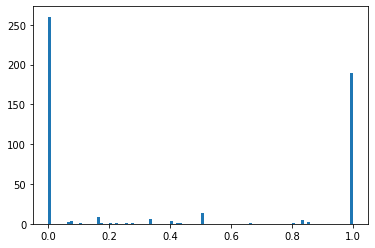

In [ ]:
import matplotlib.pyplot as plt

plt.hist(cover_rate,bins=100)
# plt.yscale('log')